# 2018 | Assessed Exercise in ASI

**Author:** Victor Risne  
**E-mail:** risne@eurecom.fr

In [2]:
import time
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from keras.datasets import cifar10, fashion_mnist
from sklearn.metrics import confusion_matrix, mean_squared_error

warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [3]:
(fm_x_train, fm_y_train), (fm_x_test, fm_y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 1s 0us/step


In [4]:
(c_x_train, c_y_train), (c_x_test, c_y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 31s 0us/step


In [5]:
fm_classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
c_classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

In [6]:
# TODO make nicer plot of the images with corresponding label
def plot_classes(X, y, classes):
    fig, ax = plt.subplots(1, len(classes), figsize=(20, 3))
    y = y.reshape(-1)
    for i, c in enumerate(classes):
        j = np.where(y == i)[0][0]
        if X.shape[1] != 28:
            ax[i].imshow(X[j], interpolation='spline16')
        else:
            ax[i].imshow(X[j], cmap='gray', interpolation='spline16')
        ax[i].set_title(c)
        ax[i].get_xaxis().set_visible(False)
        ax[i].get_yaxis().set_visible(False)
    plt.show()

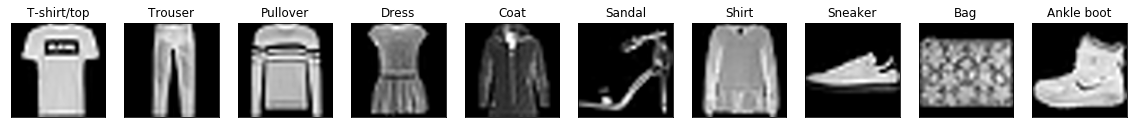

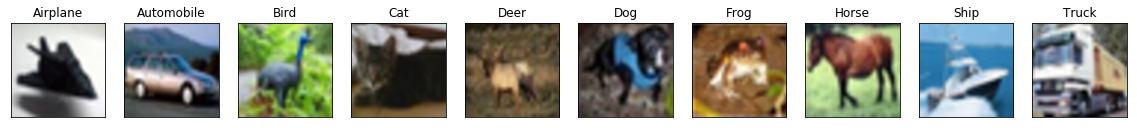

In [7]:
plot_classes(fm_x_train, fm_y_train, fm_classes)
plot_classes(c_x_train, c_y_train, c_classes)

## Shaping the data

In [8]:
print('Fashion MNIST:\t', fm_x_train.shape, '\nCIFAR10:\t', c_x_train.shape)

Fashion MNIST:	 (60000, 28, 28) 
CIFAR10:	 (50000, 32, 32, 3)


In [9]:
# Reshape data to fit the algorithms
fm_x_train_f = fm_x_train.reshape(60000, -1) / 255
fm_y_train_f = fm_y_train.flatten()
fm_x_test_f = fm_x_test.reshape(10000, -1) / 255
fm_y_test_f = fm_y_test.flatten() 

c_x_train_f = c_x_train.reshape(50000, -1) / 255
c_y_train_f = c_y_train.flatten()
c_x_test_f = c_x_test.reshape(10000, -1) / 255
c_y_test_f = c_y_test.flatten()

In [10]:
print('TRAIN\nF_MNIST X:', fm_x_train_f.shape, 
      '\tY:', fm_y_train_f.shape, '\nCIFAR10 X:',
      c_x_train_f.shape, '\tY:', c_y_train_f.shape)

TRAIN
F_MNIST X: (60000, 784) 	Y: (60000,) 
CIFAR10 X: (50000, 3072) 	Y: (50000,)


In [11]:
print('TEST\nF_MNIST X:', fm_x_test_f.shape, 
      '\tY:', fm_y_test_f.shape, '\nCIFAR10 X:', 
      c_x_test_f.shape, '\tY:', c_y_test_f.shape)

TEST
F_MNIST X: (10000, 784) 	Y: (10000,) 
CIFAR10 X: (10000, 3072) 	Y: (10000,)


The dimesionality of our features are $(10000, 784)$ and $(10000, 3072)$ this is due to the fact that I flatten the two and three dimensional array into a single array, thus making $28*28 \rightarrow 784$ and $32*32*3 \rightarrow 3072$ number of features. This needs to be done in order for the Bayesien model to interpret the intput in a correct way. Though, flatten this information will make the image loose context. However this transformation will not impact the performance of the classifier nor the regressor since I'm using Naive Bayes which uses the naive assumption that every pixel is independent from each other.

In [12]:
print(Counter(fm_y_train_f))
print(Counter(c_y_train_f))

Counter({0: 6000, 1: 6000, 2: 6000, 3: 6000, 4: 6000, 5: 6000, 6: 6000, 7: 6000, 8: 6000, 9: 6000})
Counter({0: 5000, 1: 5000, 2: 5000, 3: 5000, 4: 5000, 5: 5000, 6: 5000, 7: 5000, 8: 5000, 9: 5000})


As one can observe the classes of both fashion MNIST and CIFAR10 are evenly distibuted. When using smaller datasets the prior would have bigger influence than in our case. When dealing with datasets of the same size of fashion MNIST and CIFAR10 the prior term gets insignificant.

I also mentioned earlier that the classifier assume that there is independence between every pixel, thus making it incapable of capturing context. However one could implement a CNN (see bonus question) that captures these features that depend upon another and take the kernel outputs and use them as the features for the Bayesian classifier. If we exclude the use of CNN we could instead make use of PCA of the data to reduce the number of features, thus making both the regressor and the classifier faster. Though this method won't yield any performace improvments since we are only reducing the dimensionality while trying to preserve the most important features. However I do normalize the data to range between $(0, 1)$ instead of $(0, 255)$, this is mostly due to the fact that feature scaling can sometimes improve the convergence speed of gradient descent, and I want to use the same data later when combining the CNN with the Bayesian classifier.

The naive Bayes classifier is good in several ways, for an example it is really light on computation and also quite easy to implement as one can observe below. The classifier however, as previously mentioned, depends on the naive assumption that every feature is independent from one another. Thus making a simplification which might hurt the performance of the model which it should since we are classifying images where the pixel position matters.

# Classifier

In [13]:
class NBClassifier(object):
    def fit(self, X, y, epsilon=1e-2):
        self.gaussians = {}
        self.priors = {}
        labels = set(y)
        for c in labels:
            # Fetch all the X belonging to class c
            class_x = X[y == c]
            
            # Compute the mean and the variance for the guassian in c
            mu = class_x.mean(axis=0)
            var = class_x.var(axis=0)
            self.gaussians[c] = {'var': var + epsilon, 'mu': mu}
            
            # Compute the prior for class c
            self.priors[c] = len(class_x) / len(X)

    def predict(self, X):
        def log_likelihood(X, mu, var):
            return - .5 * np.sum(np.log(2 * np.pi * var)) - .5 * np.sum(((X - mu) ** 2) / var, 1)
        N, D = X.shape
        K = len(self.priors)
        P = np.zeros((N, K))
        for c, g in self.gaussians.items():
            mu, var = g['mu'], g['var']
            P[:,c] = log_likelihood(X, mu, var) + np.log(self.priors[c])
        return np.argmax(P, axis=1)

In [14]:
def accuracy(actual, prediction):
    return np.mean(actual == prediction)

## Fashion MNIST

In [15]:
fm_clf = NBClassifier()

t0 = time.time()
fm_clf.fit(fm_x_train_f, fm_y_train_f)
print('Fiting the data took {:.2f} seconds.'.format(time.time() - t0))

t0 = time.time()
fm_pred = fm_clf.predict(fm_x_test_f)
print('Predicting new data took {:.2f} seconds.'.format(time.time() - t0))

Fiting the data took 0.43 seconds.
Predicting new data took 0.73 seconds.


In [16]:
print('Accuracy on Fashion MNIST is {:.2f}%'.format(accuracy(fm_y_test_f, fm_pred) * 100))

Accuracy on Fashion MNIST is 67.29%


## CIFAR10

In [17]:
c_clf = NBClassifier()

t0 = time.time()
c_clf.fit(c_x_train_f, c_y_train_f)
print('Fiting the data took {:.2f} seconds.'.format(time.time() - t0))

t0 = time.time()
c_pred = c_clf.predict(c_x_test_f)
print('Predicting new data took {:.2f} seconds.'.format(time.time() - t0))

Fiting the data took 1.40 seconds.
Predicting new data took 2.83 seconds.


In [18]:
print('Accuracy on CIFAR10 is {:.2f}%'.format(accuracy(c_y_test_f, c_pred) * 100))

Accuracy on CIFAR10 is 28.18%


## Confusion matrix

In [62]:
def plot_heatmap(c_cm, fm_cm):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    sns.heatmap(c_cm.T, cmap="Oranges", ax=ax[1], vmin=0, vmax=1000, annot=True, fmt="d")
    ax[1].set_xlabel('True label')
    ax[1].set_ylabel('Predicted label')
    ax[1].set_title('CIFAR10')
    ax[1].set_xticklabels(c_classes, rotation=45)
    ax[1].set_yticklabels(c_classes, rotation=0)

    sns.heatmap(fm_cm.T, cmap="Oranges", ax=ax[0], vmin=0, vmax=1000, annot=True, fmt="d")
    ax[0].set_xlabel('True label')
    ax[0].set_ylabel('Predicted label')
    ax[0].set_title('Fashion MNIST')
    ax[0].set_xticklabels(fm_classes, rotation=45)
    ax[0].set_yticklabels(fm_classes, rotation=0)

    plt.suptitle('Confusion matrix of the two datasets')
    plt.show()

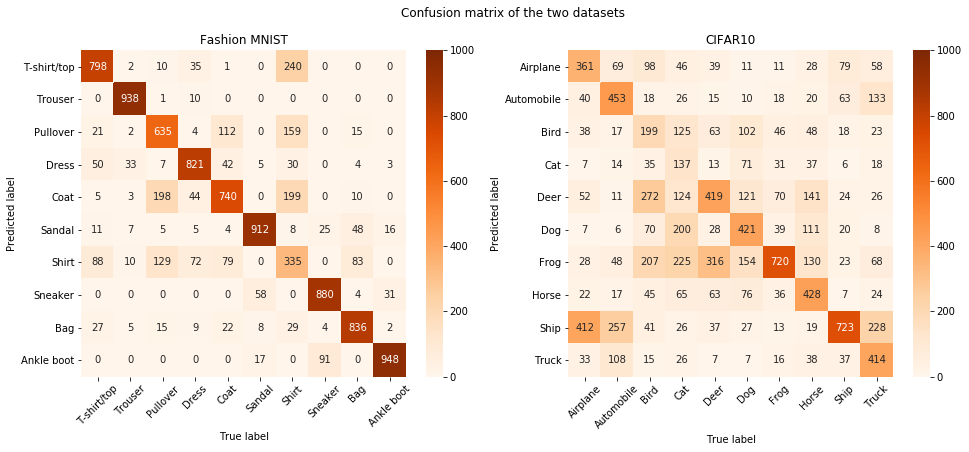

In [63]:
c_cm = confusion_matrix(c_y_test_f, c_pred)
fm_cm = confusion_matrix(fm_y_test_f, fm_pred)

plot_heatmap(c_cm, fm_cm)

$$\text{Fashion MNIST accuracy } = 67.29\%$$ 
$$\text{CIFAR10 accuracy } = 28.18\%$$

The classifier on both datasets peforms better than a random classifier. Though, the classifier works much better with the fashion MNIST dataset. However, one could argue that the classifier would perform better if we merged some of the classes. For an example, if you recall how the images look it's hard to deny that both sandal, sneaker and ankle boots holds the same shape which makes them prune to miss classification. The same goes for the pullover, coat and shirt labels, groouping these would also improve the accuracy of the model. This would also make the model more robust to, for an example, [f1-scoring](https://en.wikipedia.org/wiki/F1_score) which is the harmonic mean of Recall and Precision.

# Regressor

In [21]:
class NBRegressor(object):
    def fit(self, X, t, epsilon=1e-4):
        X = np.matrix(np.column_stack([np.ones(X.shape[0]), X]))
        t = t.reshape(-1, 1)
        
        # Prior
        S = 23 * np.identity(len(X[0]))

        # Maximum likelihood
        w_hat = (X.T.dot(X)).I.dot(X.T).dot(t)
        self.var = mean_squared_error(t, X.dot(w_hat))

        # Posterior
        self.cov = (X.T.dot(X) / (self.var + epsilon) + np.linalg.inv(S)).I
        self.mu = self.cov.dot(X.T).dot(t) / (self.var + epsilon)

    def predict(self, X):
        X = np.matrix(np.column_stack([np.ones(X.shape[0]), X]))
        new_mu = X * self.mu
        new_var = self.var + np.diagonal(X.dot(self.cov.I).dot(X.T))
        
        return np.array(new_mu).reshape(-1), new_var

## Fashion MNIST

In [22]:
fm_reg = NBRegressor()

t0 = time.time()
fm_reg.fit(fm_x_train_f, fm_y_train_f)
print('Fiting the data took {:.2f} seconds.'.format(time.time() - t0))

t0 = time.time()
fm_pred_r, _ = fm_reg.predict(fm_x_test_f)
print('Predicting new data took {:.2f} seconds.'.format(time.time() - t0))

Fiting the data took 55.14 seconds.
Predicting new data took 30.62 seconds.


In [23]:
MSE = mean_squared_error(fm_y_test_f, fm_pred_r)
print('Our predicted data on the Fashion MNIST dataset has a mean squared error of {:.2f}'.format(MSE))

Our predicted data on the Fashion MNIST dataset has a mean squared error of 1.97


## CIFAR10

In [24]:
c_reg = NBRegressor()

t0 = time.time()
c_reg.fit(c_x_train_f, c_y_train_f)
print('Fiting the data took {:.2f} seconds.'.format(time.time() - t0))

t0 = time.time()
c_pred_r, _ = c_reg.predict(c_x_test_f)
print('Predicting new data took {:.2f} seconds.'.format(time.time() - t0))

Fiting the data took 220.80 seconds.
Predicting new data took 92.21 seconds.


In [25]:
MSE = mean_squared_error(c_y_test_f, c_pred_r)
print('Our predicted data on the CIFAR10 dataset has a mean squared error of {:.2f}'.format(MSE))

Our predicted data on the CIFAR10 dataset has a mean squared error of 8.03


## Scatter plot of predictions

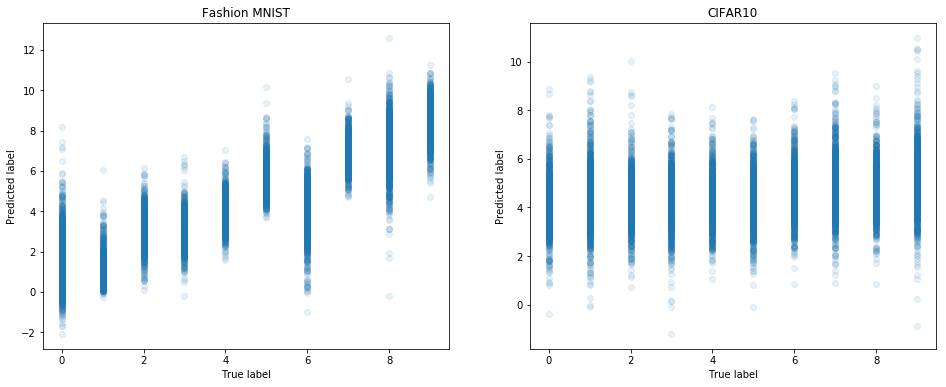

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].scatter(fm_y_test_f, fm_pred_r, alpha=0.1)
ax[0].set_title('Fashion MNIST')
ax[0].set_xlabel('True label')
ax[0].set_ylabel('Predicted label')
ax[1].scatter(c_y_test_f, c_pred_r, alpha=0.1)
ax[1].set_title('CIFAR10')
ax[1].set_xlabel('True label')
ax[1].set_ylabel('Predicted label')
plt.show()

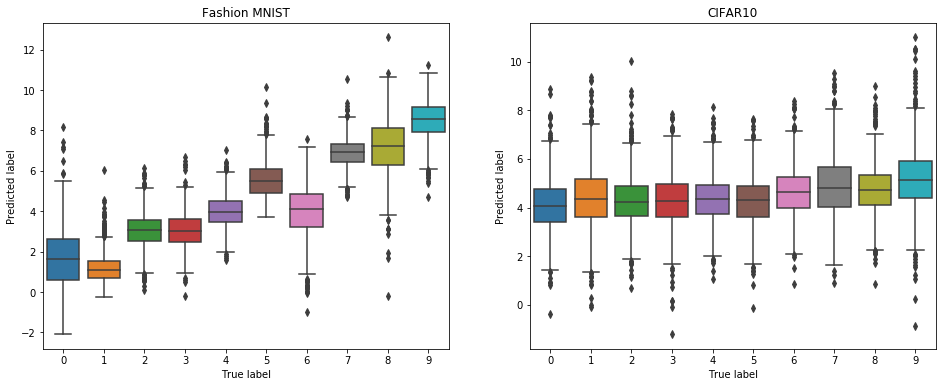

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(fm_y_test_f, fm_pred_r, ax=ax[0])
ax[0].set_title('Fashion MNIST')
ax[0].set_xlabel('True label')
ax[0].set_ylabel('Predicted label')
sns.boxplot(c_y_test_f, c_pred_r, ax=ax[1])
ax[1].set_title('CIFAR10')
ax[1].set_xlabel('True label')
ax[1].set_ylabel('Predicted label')
plt.show()

Both the scatter plot and box plot indicates that the regressor makes a decent effort when it's predicting on the fashion MNIST. Though, one can see that the variance is quite high which causes a lot of miss classifications among the nearby classes which isn't good. 

However on the CIFAR10 dataset it's possible to see that the regressor performs no better than a random classifier. Among all the classes the mean seems to be around $4$ to $5$ and also holds a high variance where every class is almost miss classified among every other class at least once. Since the regressor mostly predicts $4$ and $5$ the regressor mostly thinks that the images are either a deer $(4)$ or a dog $(5)$.

## Discretize data

In [28]:
fm_pred_r_disc = np.clip([int(round(f)) for f in fm_pred_r], 0, 9)
c_pred_r_disc = np.clip([int(round(f)) for f in c_pred_r], 0, 9)

In [29]:
A = set(range(10))
assert(set(fm_pred_r_disc) == A and set(c_pred_r_disc) == A), 'The data was not correctly discretized'

Without making things to complicated I suggest that we round every prediction to the closest integer and later proceeding with clipping the range so that the numbers only can live within the range of $(0,1, \ldots,9)$. Above you can see how I've implemented it and how I've also asserted my self that it in fact gave me only discrete values from $0$ to $9$.

## Accuracy

In [30]:
print('Accuracy on Fashion MNIST is {:.2f}%'.format(accuracy(fm_y_test_f, fm_pred_r_disc) * 100))
print('Accuracy on CIFAR10 is {:.2f}%'.format(accuracy(c_y_test_f, c_pred_r_disc) * 100))

Accuracy on Fashion MNIST is 38.60%
Accuracy on CIFAR10 is 10.95%


Both the accuracy of the fashion MNIST and the CIFAR10, while running the regressor, were worse of than the classifier. Furthermore tests on the CIFAR10 dataset yields same accuracy as a random classifier would achieve, thus making it no better than making a wild guess or rolling a ten-sided dice.

## Confusion matrix

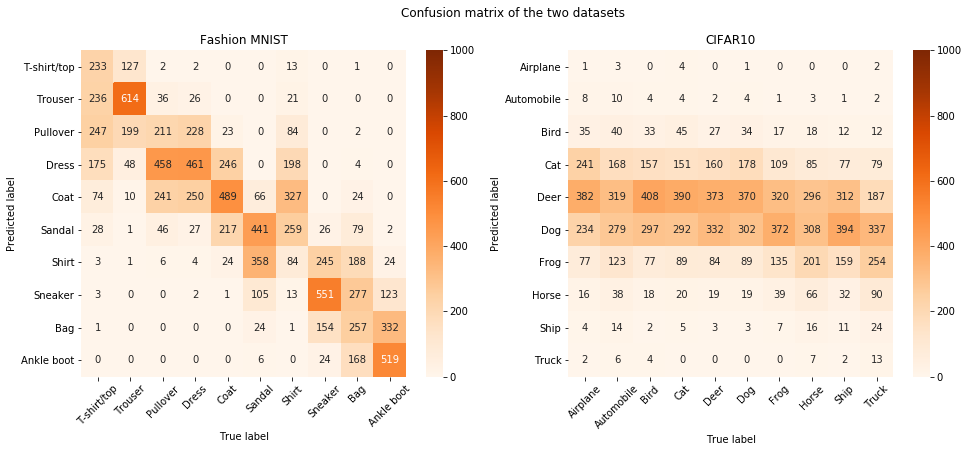

In [64]:
c_cm = confusion_matrix(c_y_test_f, c_pred_r_disc)
fm_cm = confusion_matrix(fm_y_test_f, fm_pred_r_disc)

plot_heatmap(c_cm, fm_cm)

$$\text{Fashion MNIST accuracy } = 38.60\%$$ 
$$\text{CIFAR10 accuracy } = 10.95\%$$

The biggest limitation I can observe is that the variance is too high for the model to be accurate enough. For an example, the predictions made on the fashion MNIST dataset shows that the model more or less gets a reasonable regression on the data. However since the variance is quite high it's not possbile to achive the same accuracy as the classifier. However, once again as I did in the classification section, I'll inspect the miss classifications made. As one can recall, the some miss classifications on sneakers were either sandals or ankle boot. This makes perfect sense in a classification task, however this property is lost once we do regression, only the nearby classes will get the miss classifications. Thus confusing sneakers with shirts and bags which makes the use of regression for this task not suitible.

# Bonus question

In [32]:
from keras import Sequential, optimizers
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from keras.callbacks import EarlyStopping, TensorBoard
from keras.preprocessing.sequence import pad_sequences
import pandas as pd

In [33]:
# Reshape and normalize data to to fit between (0, 1) instead of (0, 255)
fm_x_train_c = fm_x_train.reshape(-1, 28, 28, 1) / 255
c_x_train_c = c_x_train / 255
fm_x_test_c = fm_x_test.reshape(-1, 28, 28, 1) / 255
c_x_test_c = c_x_test / 255

# Get the shapes of the training data
fm_shape = fm_x_train_c[0].shape
c_shape = c_x_train_c[0].shape

# Create one hot vectors of the labels
fm_y_train_c = to_categorical(fm_y_train)
c_y_train_c = to_categorical(c_y_train)

## Define LeNet

In [34]:
def build_model(input_shape):
    model = Sequential()
    model.add(Conv2D(6, (5, 5), padding='valid', activation = 'relu', kernel_initializer='he_normal', 
                     input_shape=input_shape))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(16, (5, 5), padding='valid', activation = 'relu', kernel_initializer='he_normal'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Flatten(name="conv_output"))
    model.add(Dense(120, activation = 'relu', kernel_initializer='he_normal'))
    model.add(Dense(84, activation = 'relu', kernel_initializer='he_normal'))
    model.add(Dense(10, activation = 'softmax', kernel_initializer='he_normal'))
    adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    return model

In [35]:
# Define two different models for the fashion MNIST and CIFAR10 dataset
fm_model = build_model(fm_shape)
c_model = build_model(c_shape)

# Information about the fashion MNIST model
fm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 6)         156       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 16)          2416      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
conv_output (Flatten)        (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               30840     
_________________________________________________________________
dense_2 (Dense)              (None, 84)                10164     
__________

## Fit networks on LeNet

In [41]:
# Defining callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')
tensor_board = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True)

cbks = [early_stopping, tensor_board]

In [42]:
def plot_csv(data):
    val_acc = pd.read_csv(data + '_val_acc.csv')
    acc = pd.read_csv(data + '_acc.csv')

    y_val_acc = val_acc['Value'] * 100
    x_val_acc = val_acc['Step']
    y_acc = acc['Value'] * 100
    x_acc = acc['Step']

    sns.set()
    fig, ax = plt.subplots(1, 1, figsize=(16, 9))
    ax.plot(x_val_acc, y_val_acc, label='Validation accuracy', lw=3)
    ax.plot(x_acc, y_acc, label='Training accuracy', lw=3, ls='--')
    ax.set_title('Accuracy over time')
    ax.set_ylabel('Accuracy in %')
    ax.set_xlabel('Step')
    ax.legend()
    plt.show()

In [43]:
t0 = time.time()
fm_model.fit(fm_x_train_c, fm_y_train_c, validation_split=.1, batch_size=128, 
             epochs=100, shuffle=True, verbose=0, callbacks=cbks)
print('Fiting the data took {:.2f} seconds.'.format(time.time() - t0))

Fiting the data took 571.66 seconds.


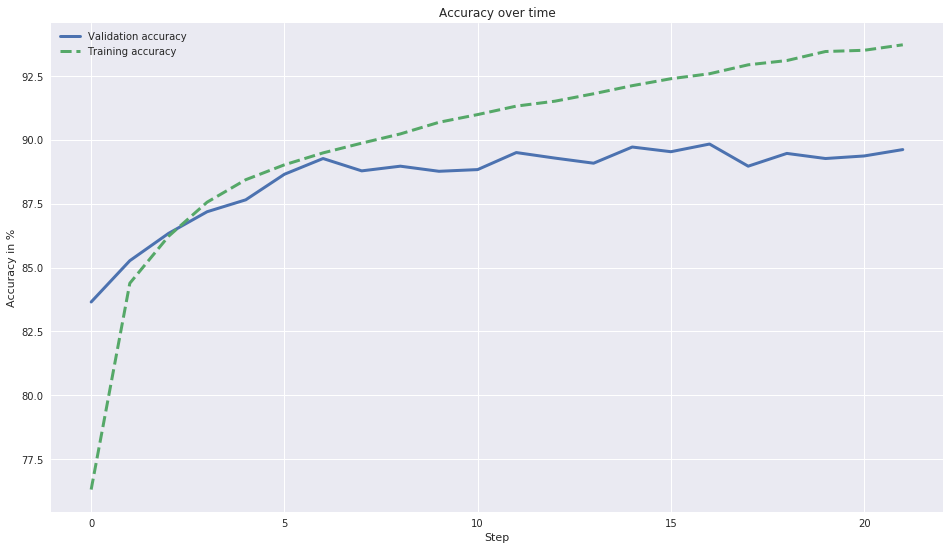

In [141]:
plot_csv('./figures/fm')

In [44]:
t0 = time.time()
c_model.fit(c_x_train_c, c_y_train_c,  validation_split=.1, batch_size=128, 
            epochs=100, shuffle=True, verbose=0, callbacks=cbks)
print('Fiting the data took {:.2f} seconds.'.format(time.time() - t0))

Fiting the data took 933.63 seconds.


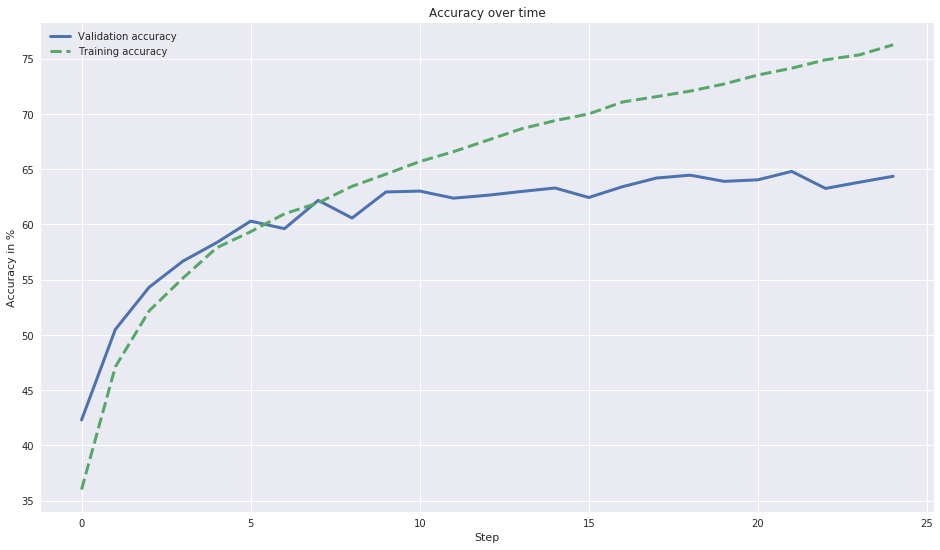

In [142]:
plot_csv('./figures/c')

## Fashion MNIST

In [45]:
fm_pre_bayesian = Model(inputs=fm_model.input, outputs=fm_model.get_layer('conv_output').output)
fm_c_clf = NBClassifier()

In [46]:
t0 = time.time()
fm_pre_train = fm_pre_bayesian.predict(fm_x_train_c)
fm_c_clf.fit(fm_pre_train, fm_y_train_f)
print('Fiting the data took {:.2f} seconds.'.format(time.time() - t0))

t0 = time.time()
fm_pre_test = fm_pre_bayesian.predict(fm_x_test_c)
fm_pred_c = fm_c_clf.predict(fm_pre_test)
print('Predicting new data took {:.2f} seconds.'.format(time.time() - t0))

Fiting the data took 9.00 seconds.
Predicting new data took 1.68 seconds.


In [47]:
print('CNN + Naive Bayes | Accuracy on Fashion MNIST is {:.2f}%'.format(accuracy(fm_y_test_f, fm_pred_c) * 100))

CNN + Naive Bayes | Accuracy on Fashion MNIST is 78.43%


## CIFAR10

In [48]:
c_pre_bayesian = Model(inputs=c_model.input, outputs=c_model.get_layer('conv_output').output)
c_c_clf = NBClassifier()

In [49]:
t0 = time.time()
c_pre_train = c_pre_bayesian.predict(c_x_train_c)
c_c_clf.fit(c_pre_train, c_y_train_f)
print('Fiting the data took {:.2f} seconds.'.format(time.time() - t0))

t0 = time.time()
c_pre_test = c_pre_bayesian.predict(c_x_test_c)
c_pred_c = c_c_clf.predict(c_pre_test)
print('Predicting new data took {:.2f} seconds.'.format(time.time() - t0))

Fiting the data took 16.89 seconds.
Predicting new data took 3.22 seconds.


In [50]:
print('CNN + Naive Bayes | Accuracy on CIFAR10 is {:.2f}%'.format(accuracy(c_y_test_f, c_pred_c) * 100))

CNN + Naive Bayes | Accuracy on CIFAR10 is 42.75%


- **CLF** is a shorthand for Naive Bayesian Classifier
- **REG** is a shorthand for Naive Bayesian Regressor
- **CNN** is a shorthand for Convolutional Neural Network (LeNet)

Model | Accuracy on f-MNIST | Accuracy on CIFAR10 
:--- | :---: | :---:
**CLF** | `67.29%` | `28.18%`
**REG**| `38.60%` | `10.95%`
**CNN + CLF**| `78.43%` | `42.75%` 

If you compare the graphs above one can spot that the validation accuracy is even higher than the accuracy achieved when combining CNN + CLF. However it's possible to see that extracting features with a CNN and then using the features as an input to the Bayesian classifier, I get an accuracy improvment of around $10\%$ points. Thus we can capture the pixel relations and then utilize the naive assumption that the features are independant with our classifier. This experiment really shows that the naive assumption isn't a correct. Therefore it's easy to see that using convolutional layers to reduce the features and capturing the high level of pixel dependency gives better results.